In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
df1 = pd.read_csv("data/야수_전처리_ver12.csv")
df2 = pd.read_csv("data/2026_FA예정_타자.csv")

In [3]:
# 계약금 컬럼 생성
df1['FA 계약 총액'] = df1['FA 계약 총액'].fillna(0)
df1['연봉'] = df1['연봉'].fillna(0)
df1['계약금'] = df1['FA 계약 총액'] + df1['연봉']

In [4]:
# 전처리 함수 정의
def preprocess(df):
    df = df.copy()
    if '구분' in df.columns:
        df = df[~df['구분'].isin(['해외', 'FA 1년차'])]
    if 'FA등급' in df.columns:
        df = df[~df['FA등급'].isin(['해외', 'FA 1년차'])]
    if '플레이년도' in df.columns:
        df = df[df['플레이년도'] > 2015]

    drop_cols = ['선수명_수정', 'FA 계약 총액', '연봉', '잔류여부']
    df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')
    df = df.groupby('선수명', as_index=False).mean(numeric_only=True)
    return df

df1_cleaned = preprocess(df1)
df2_cleaned = preprocess(df2)

C:\Users\Lee\AppData\Local\Temp\ipykernel_12200\3216511609.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.values, y=correlations.index, palette='Blues_d')


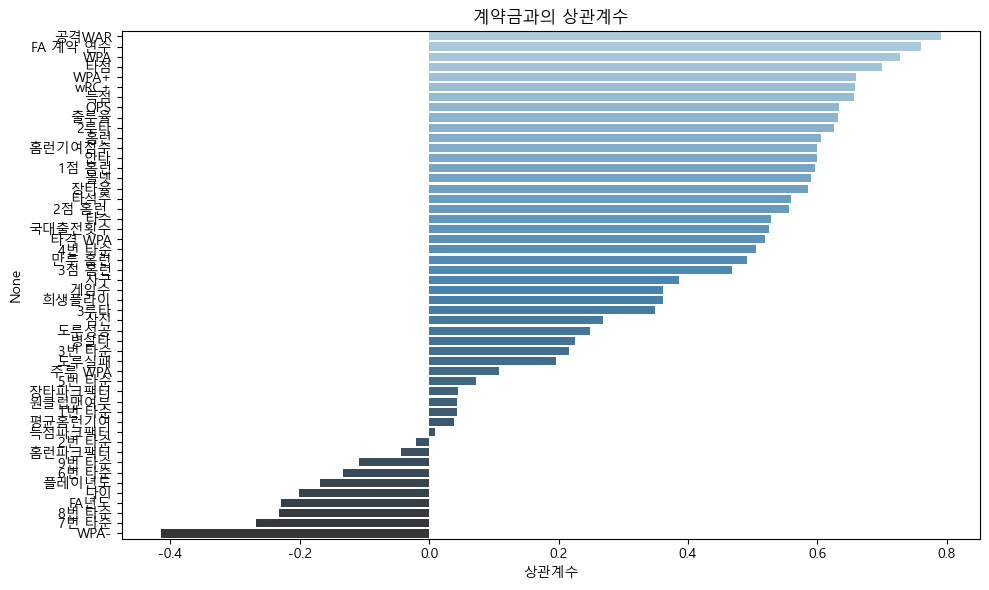

In [5]:
# 상관계수 및 가중치 계산
correlations = df1_cleaned.corr(numeric_only=True)['계약금'].drop('계약금').sort_values(ascending=False)
weights = correlations.abs() / correlations.abs().sum()
weight_df = pd.DataFrame({'컬럼명': weights.index, '가중치': weights.values})

# 시각화
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.values, y=correlations.index, palette='Blues_d')
plt.title('계약금과의 상관계수')
plt.xlabel('상관계수')
plt.tight_layout()
plt.show()

In [6]:
# 예측에 사용할 피처 선택
predict_features = [f for f in weights.index if f in df1_cleaned.columns and f in df2_cleaned.columns]
X = df1_cleaned[predict_features]
y = df1_cleaned['계약금']
Xy = pd.concat([X, y], axis=1).dropna()
X = Xy[predict_features]
y = Xy['계약금']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = df2_cleaned[predict_features]

In [7]:
# Optuna로 하이퍼파라미터 튜닝 
def objective(trial):
    params = {
        'iterations': trial.suggest_categorical('iterations', [300, 500, 700]),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_strength': trial.suggest_float('random_strength', 1, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'verbose': 0,
        'random_seed': 42
    }
    model = CatBoostRegressor(**params)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()
    return -score

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

[I 2025-08-06 15:14:10,770] A new study created in memory with name: no-name-9c5097c6-1f01-486e-bcc2-f3fd70576295
[I 2025-08-06 15:14:13,484] Trial 0 finished with value: 108236.22419642103 and parameters: {'iterations': 700, 'depth': 6, 'learning_rate': 0.06777171240019564, 'l2_leaf_reg': 9.694857387008925, 'random_strength': 8.614824009040056, 'bagging_temperature': 0.5039244450961883}. Best is trial 0 with value: 108236.22419642103.
[I 2025-08-06 15:14:15,095] Trial 1 finished with value: 115186.15875543363 and parameters: {'iterations': 300, 'depth': 7, 'learning_rate': 0.2575933511951975, 'l2_leaf_reg': 4.490618372750264, 'random_strength': 6.4348002360114345, 'bagging_temperature': 0.3785048470908051}. Best is trial 0 with value: 108236.22419642103.
[I 2025-08-06 15:14:19,259] Trial 2 finished with value: 122377.18488193485 and parameters: {'iterations': 500, 'depth': 8, 'learning_rate': 0.13687283636924036, 'l2_leaf_reg': 4.214204631492102, 'random_strength': 4.984390757568304, 

In [8]:
# 최적 모델 학습 및 검증
best_params = study.best_params
best_model = CatBoostRegressor(**best_params)
best_model.fit(X_train, y_train)

val_pred = best_model.predict(X_val)

mse = mean_squared_error(y_val, val_pred)  
rmse = mean_squared_error(y_val, val_pred, squared=False)
mae = mean_absolute_error(y_val, val_pred)
r2 = r2_score(y_val, val_pred)

print(f"[모델 평가 지표]")
print(f" MSE : {mse:,.2f}")
print(f" RMSE: {rmse:,.2f}")
print(f" MAE : {mae:,.2f}")
print(f" R²  : {r2:.4f}")

print("[CatBoost + Optuna] 최적 파라미터:")
print(best_params)

0:	learn: 164781.5835527	total: 537us	remaining: 268ms
1:	learn: 159585.0780555	total: 1.16ms	remaining: 288ms
2:	learn: 154781.9286362	total: 1.67ms	remaining: 276ms
3:	learn: 150380.4430778	total: 2.15ms	remaining: 266ms
4:	learn: 146657.1850037	total: 2.55ms	remaining: 252ms
5:	learn: 142373.6667558	total: 2.89ms	remaining: 238ms
6:	learn: 139875.1375649	total: 5.1ms	remaining: 359ms
7:	learn: 135624.1519881	total: 6.08ms	remaining: 374ms
8:	learn: 132501.8180891	total: 7.09ms	remaining: 387ms
9:	learn: 128530.1047802	total: 7.72ms	remaining: 378ms
10:	learn: 126754.1290509	total: 8.29ms	remaining: 368ms
11:	learn: 124501.7522571	total: 8.85ms	remaining: 360ms
12:	learn: 122243.1082954	total: 9.29ms	remaining: 348ms
13:	learn: 120494.3285487	total: 9.67ms	remaining: 336ms
14:	learn: 117347.9561351	total: 10ms	remaining: 324ms
15:	learn: 114213.2845101	total: 10.4ms	remaining: 315ms
16:	learn: 111586.4287864	total: 10.8ms	remaining: 306ms
17:	learn: 107865.7649151	total: 11.1ms	remai

C:\Users\Lee\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [9]:
# 계약금 예측 및 반올림
df2_cleaned['계약금'] = best_model.predict(X_test).round(0).astype(int)

C:\Users\Lee\AppData\Local\Temp\ipykernel_12200\406754386.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, y='컬럼명', x='중요도 (CatBoost)', palette='PuBuGn')


피처 중요도 (CatBoost + Optuna):
       컬럼명  중요도 (CatBoost)  상관계수 기반 가중치
0    공격WAR       19.324318     0.040855
17  국대출전횟수       17.436506     0.027093
42      나이        6.646539     0.010384
4     wRC+        5.981719     0.033973
29   3번 타순        4.018294     0.011183
15     타석수        3.461508     0.028906
32   5번 타순        2.895015     0.003776
7      출루율        2.811312     0.032661
24   희생플라이        2.585081     0.018636
34  원클럽맨여부        2.438533     0.002259
38  홈런파크팩터        2.210526     0.002225
5       득점        1.964601     0.033944
22      사구        1.840161     0.019909
26      삼진        1.700852     0.013870
11      안타        1.693620     0.030939
12   1점 홈런        1.576935     0.030799
40   6번 타순        1.396028     0.006862
1      WPA        1.372928     0.037568
13      볼넷        1.243291     0.030449
6      OPS        1.223653     0.032738
20   만루 홈런        1.218893     0.025381
8      2루타        1.198878     0.032353
25     3루타        1.121662     0.018032
36  득점파크팩터  

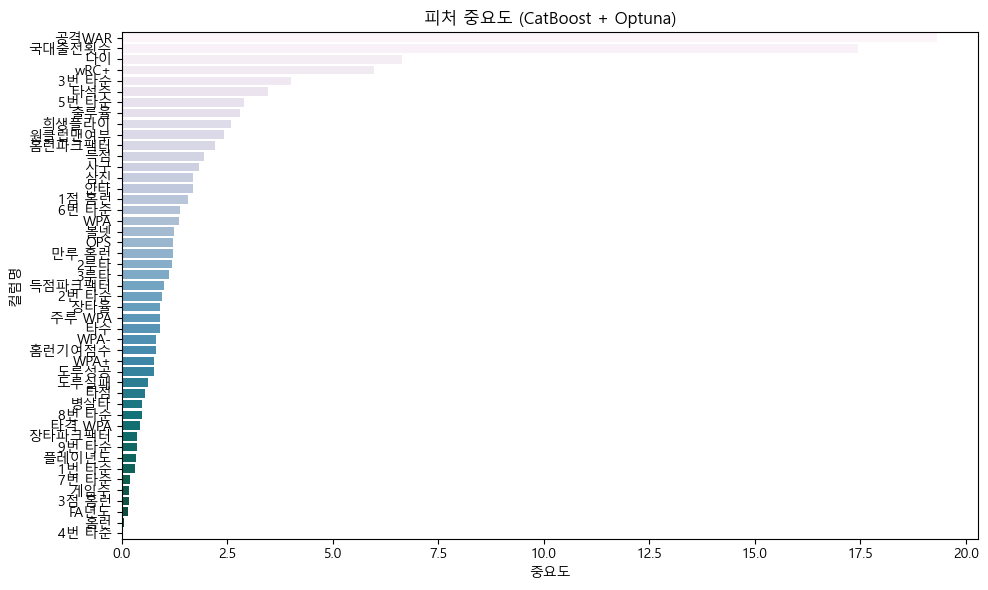

In [10]:
# 피처 중요도 분석
importance_df = pd.DataFrame({
    '컬럼명': predict_features,
    '중요도 (CatBoost)': best_model.feature_importances_,
    '상관계수 기반 가중치': [weights[f] for f in predict_features]
}).sort_values(by='중요도 (CatBoost)', ascending=False)

print("피처 중요도 (CatBoost + Optuna):")
print(importance_df)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, y='컬럼명', x='중요도 (CatBoost)', palette='PuBuGn')
plt.title('피처 중요도 (CatBoost + Optuna)')
plt.xlabel('중요도')
plt.tight_layout()
plt.show()

In [11]:
# 예측 결과 출력
print("예측 계약금 상위 선수 (CatBoost + Optuna):")
print(df2_cleaned[['선수명', '계약금']].sort_values(by='선수명', ascending=True))

예측 계약금 상위 선수 (CatBoost + Optuna):
    선수명     계약금
0   강민호  212149
1   강백호  171888
2   김재환  175631
3   박병호  158351
4   박승욱   56488
5   박찬호  186187
6   박해민  187902
7   손아섭  159087
8   이재원   58662
9   장성우  104910
10   정훈   40545
11  조수행   92662
12  최원준  135051
13  최형우  228211
14  황재균  131934
